In [1]:
from google.colab import drive

drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
# Download dependencies
!pip install pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os

In [3]:
os.chdir("/content/gdrive/MyDrive/Colab_Notebooks/Fault_detection")

In [4]:
# import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from utils.elpv_reader import load_dataset
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

# Dataset Exploration

## Loading the dataset

In [5]:
def load_data():
  images, probas, labels = load_dataset()

  # Convert the type of the solar module 
  # to numerical values
  labels[labels == "mono"] = 0
  labels[labels == "poly"] = 1

  # Convert the probabilities to classes
  probas[probas >= 0.5] = 1. # the cell is defective
  probas[probas < 0.5] = 0. # the cell is not defective

  # Convert grayscale to rgb
  # This is needed to adapt the data
  # to the model's input format
  rgb_imgs = np.repeat(images[..., np.newaxis],3,-1)
  
  # The images and the type of the cell
  # are going to be the inputs to our model
  X1 = rgb_imgs
  X2 = labels

  # The probabilities of being defective
  # are going to be the outputs of our model
  Y = probas

  return X1,X2,Y

In [6]:
X1,X2,Y = load_data()

## Exploring the range of pixel intensities

In [ ]:
min_intensity = np.min(X1)
max_intensity = np.max(X1)

print(f"The range of pixel intensities is between {min_intensity}-{max_intensity}")

The range of pixel intensities is between 0-255


## Exploring the target class distribution

In [ ]:
pos_class = np.sum(Y)/len(Y)*100
neg_class = (len(Y)-np.sum(Y))/len(Y)*100

print(f'The dataset has {np.round(pos_class,2)} % defective cells and {np.round(neg_class,2)} % non-defective cells')

The dataset has 31.29 % defective cells and 68.71 % non-defective cells


## Splitting the data

In [ ]:
# splitting the dataset
# to train and validation
X1_train,X1_val,Y_train,Y_val = train_test_split(X1,Y,test_size=0.2,random_state=13,stratify=Y)
X2_train,X2_val,Y_train,Y_val = train_test_split(X2,Y,test_size=0.2,random_state=13,stratify=Y)

print(f"Training set size: {X1_train.shape} \nValidation set size: {X1_val.shape}")

Training set size: (2099, 300, 300, 3) 
Validation set size: (525, 300, 300, 3)


## Visualizing the data

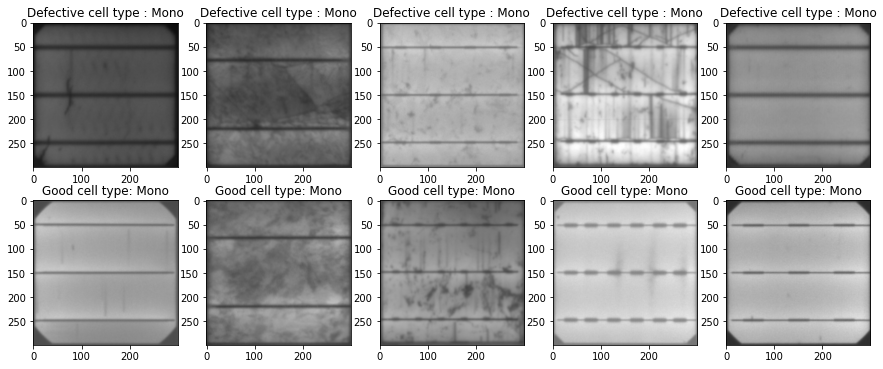

In [ ]:
import matplotlib.pyplot as plt

defective_images = X1_train[Y_train == 1][:10]
non_defective_images = X1_train[Y_train == 0][:5]

cell_types_def = X2_train[Y_train == 1.][:5]
cell_types_ndef = X2_train[Y_train ==0.][:5]

plt.figure(figsize=(15,6))

for i in range(5):
    plt.subplot(2,5,i+1)
    plt.imshow(defective_images[i,...])
    plt.title("Defective cell type : "+ ("Poly" if cell_types_ndef[i-5] == 1 else "Mono"))

for i in range(5,10):
    plt.subplot(2,5,i+1)
    plt.imshow(non_defective_images[i-5,...])
    plt.title(f"Good cell type: "+ ("Poly" if cell_types_ndef[i-5] == 1 else "Mono"))

# Data Preprocessing

In [ ]:
Y_train = to_categorical(Y_train,num_classes=2)
Y_val = to_categorical(Y_val,num_classes=2)

In [ ]:
BATCH_SIZE = 32
# this is the default size used by most of the pretrained Keras models
image_size = (224, 224)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        samplewise_center=False,
        samplewise_std_normalization=False,
        rescale=1./255,
        shear_range=0.07, # do some data augmentation here
        zoom_range=0.2,
        rotation_range=30,
        horizontal_flip=True,
        vertical_flip=True)

# create testing and validation data generator without augmentation
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        samplewise_center=False, 
        samplewise_std_normalization=False,
        rescale=1./255
        )



In [ ]:
train_ds = train_datagen.flow(x=tf.image.resize(X1_train,size=(224,224)),
                              y=Y_train, 
                              batch_size=BATCH_SIZE)
val_ds = val_datagen.flow(x=tf.image.resize(X1_val,size=(224,224)),
                          y=Y_val,
                          batch_size=BATCH_SIZE)

# Building the model

# Transfer Learning EfficientNet

In [ ]:
def create_transfer_learning_model( 
                                   fine_tune=False,
                                   fine_tune_at=None,
                                   input_shape=(224,224,3),
                                   base_learning_rate = 0.01
                                   ):
  

    inputs = tf.keras.Input(shape=input_shape)
    base_model = tf.keras.applications.EfficientNetV2B2(input_shape=input_shape, 
                                                     include_top=False,
                                                     input_tensor=inputs,
                                                     weights='imagenet',
                                                     include_preprocessing=False,
                                                   )
    # Freeze the base model
    base_model.trainable = False
    
    if fine_tune :
        if not fine_tune_at:
            raise Exception("You should specify from which"+
                            " layer the model will be fine tuned"
                            )
        else:
            base_model.trainable = True
            
            # Freeze the lowest layers 
            # and fine tune the top layers
            # starting from index "fine_tune_at"
            for layer in base_model.layers[:fine_tune_at]:
                layer.trainable = False
  
    x = base_model.output
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    outputs = layers.Dense(2,activation="softmax")(x)
    
    model = tf.keras.Model(inputs, outputs)

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                  loss= tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                  metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return model, base_model
  
model, base_model = create_transfer_learning_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 112, 112, 32  128         ['stem_conv[0][0]']              
                                )                                                             

In [ ]:
# Define Callbacks to save the best model
if not os.path.exists("./models/"):
  os.makedirs("./models/")
  
chkp_filepath= "./models/best_efficient_net_b2_final2_{epoch:02d}.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(chkp_filepath, verbose=1,
                             save_best_only=True,monitor="val_categorical_accuracy",mode='max',save_freq="epoch")

filename='logs_effecient_net_b2_final.csv'
history_logger= tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)

'Custom callback to decrease learning rate by a factor of 3 every 3rd epoch'
class DecreaseLR(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch > 4 and epoch % 2 == 0:
            self.model.optimizer.lr = self.model.optimizer.lr / 3

In [ ]:
tf.random.set_seed(64)

initial_epochs = 18

loss0, accuracy0 = model.evaluate(val_ds)

17/17 [==============================] - 12s 101ms/step - loss: 0.6213 - categorical_accuracy: 0.6876


In [ ]:
from sklearn.utils import class_weight

# Calculate the weights for each class so that we can balance the data
# y = np.argmax(Y_train,axis=-1)
# weights = class_weight.compute_class_weight(class_weight = "balanced",
#                                        classes = np.unique(y),
#                                        y = y)
# weights = dict(zip(np.unique(Y_train), weights))
weights = {0.0:0.5, 1.0:1.5}

initial_epochs = 18
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,
                    callbacks=[history_logger, checkpoint,DecreaseLR()],
                    class_weight=weights
                    )


Epoch 1/18
66/66 [==============================] - ETA: 0s - loss: 1.0448 - categorical_accuracy: 0.6465
Epoch 1: val_categorical_accuracy improved from -inf to 0.79810, saving model to ./models/best_efficient_net_b2_final2_01.h5
66/66 [==============================] - 37s 424ms/step - loss: 1.0448 - categorical_accuracy: 0.6465 - val_loss: 0.4521 - val_categorical_accuracy: 0.7981
Epoch 2/18
66/66 [==============================] - ETA: 0s - loss: 1.1372 - categorical_accuracy: 0.6698
Epoch 2: val_categorical_accuracy did not improve from 0.79810
66/66 [==============================] - 24s 359ms/step - loss: 1.1372 - categorical_accuracy: 0.6698 - val_loss: 0.5116 - val_categorical_accuracy: 0.7257
Epoch 3/18
66/66 [==============================] - ETA: 0s - loss: 0.9360 - categorical_accuracy: 0.6960
Epoch 3: val_categorical_accuracy did not improve from 0.79810
66/66 [==============================] - 24s 361ms/step - loss: 0.9360 - categorical_accuracy: 0.6960 - val_loss: 1.182

## Model Evaluation

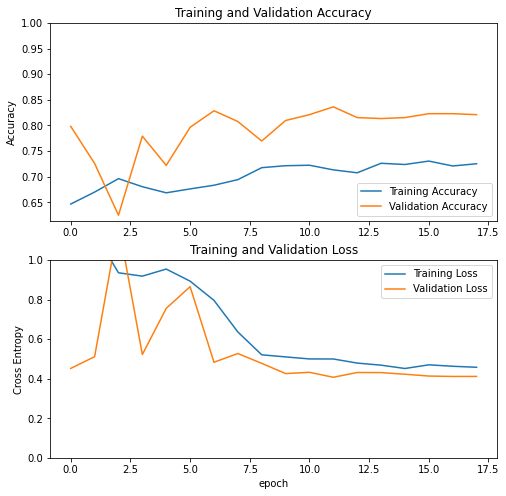

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


## Visualize Predictions

In [7]:
# Load the best model trained in the previous phase
# Notice that here I changed its name
# So that you don't confuse it with your saved model
# When reproducing the code
best_model = tf.keras.models.load_model("./models/best_model.h5")# Replace the path here with the path to your best model

1/1 [==============================] - 0s 202ms/step


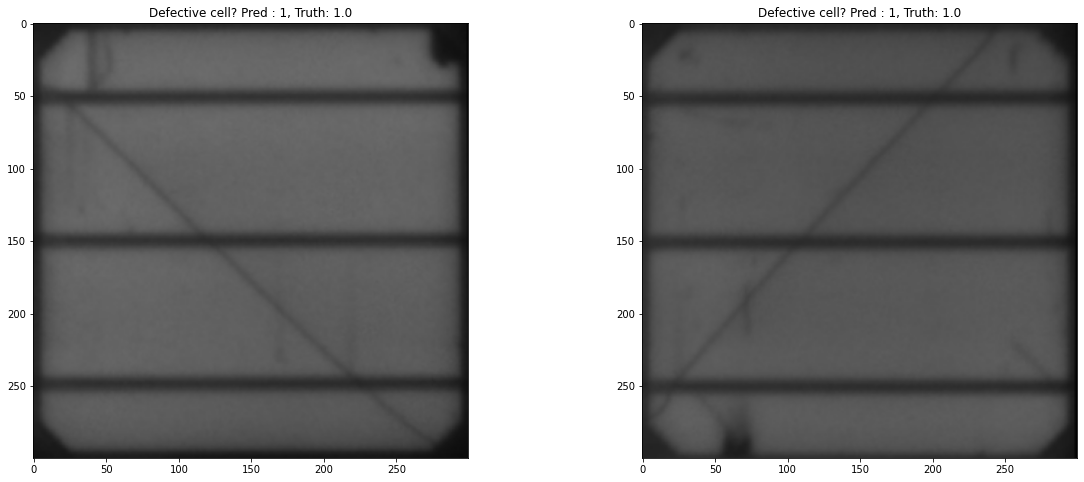

In [20]:
# Let's load only 2 images 
# from the defective cells
# Elsewhere we might run out of resources
# When using GradCam
image_btch = X1[Y == 1][1:3]
labels = Y[Y== 1][1:3]

# Preprocessing the images
images = tf.image.resize(image_btch,size=(224,224))/255.

# Running inference
predictions = best_model.predict(images)
predictions = tf.argmax(predictions,axis=-1)

plt.figure(figsize=(20,8))

for i in range(2):
  plt.subplot(1,2,i+1)
  plt.imshow(image_btch[i,...])
  plt.title(f"Defective cell? Pred : {predictions[i]}, Truth: {y_btch[i]}")
  

# GRAD-CAM

In [9]:
!pip install tf-keras-vis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 KB 3.6 MB/s eta 0:00:00


In [17]:
from matplotlib import cm
def plot_images(images=None, maps=None):
    num_images = 0
    if images is not None:
        num_images = len(images)
    else:
        num_images = len(maps)
    _, ax = plt.subplots(1, num_images, figsize=(8, 4))
    for i in range(num_images):
        alpha = 0.3
        if images is not None:
            alpha = 0.3
            image = images[i]
            ax[i].imshow((image+1)/2,alpha=0.7)
        if maps is not None:
            mp = maps[i]
            heatmap = np.uint8(cm.jet(mp)[..., :3] * 255)
            ax[i].imshow(heatmap, cmap='jet', alpha=0.3)
        ax[i].axis('off')
    plt.tight_layout()

In [11]:
#from tf_keras_vis.utils.scores import CategoricalScore
#score_function = CategoricalScore(labels.astype('int8').tolist())
# Instead of using CategoricalScore object,
# you can also define the function from scratch as follows:
def score_function(output):
    # The `output` variable refers to the output of the model,
    # so, in this case, `output` shape is  (samples, nb_classes).
    return [output[i, labels[i].astype('int8')] for i in range(output.shape[0])]

In [12]:
best_model.layers[-6].output.shape

TensorShape([None, 7, 7, 1408])

In [13]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [16]:
from tf_keras_vis.scorecam import Scorecam
# Create ScoreCAM object
scorecam = Scorecam(best_model)
# Generate heatmap with Faster-ScoreCAM
cam = scorecam(score_function, images[1:3], 
               penultimate_layer=-6,
               seek_penultimate_conv_layer= False)


88/88 [==============================] - 220s 2s/step


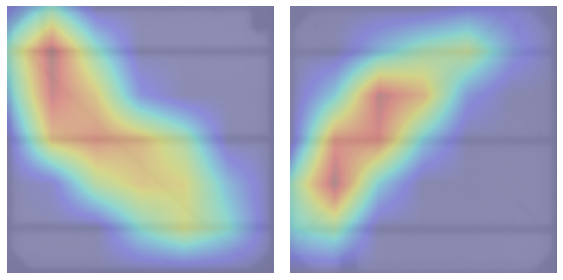

In [18]:
# Render
plot_images(images=images[1:3,...], maps=cam)